In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mido
import torch
from music21 import converter, corpus, instrument, midi, note, chord, pitch, stream
import glob
import pickle
import pandas as pd

In [2]:
# Melody-RNN Format is a sequence of 8-bit integers indicating the following:
# MELODY_NOTE_ON = [0, 127] # (note on at that MIDI pitch)
MELODY_NOTE_OFF = 128 # (stop playing all previous notes)
MELODY_NO_EVENT = 129 # (no change from previous event)
# Each element in the sequence lasts for one sixteenth note.
# This can encode monophonic music only.

def streamToNoteArray(stream):
    """
    Convert a Music21 sequence to a numpy array of int8s into Melody-RNN format:
        0-127 - note on at specified pitch
        128   - note off
        129   - no event
    """
    # Part one, extract from stream
    total_length = np.int(np.round(stream.flat.highestTime / 0.25)) # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, note.Note):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.pitch.midi])
        elif isinstance(element, chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=np.int)
    df = pd.DataFrame({'pos': np_stream_list.T[0], 'dur': np_stream_list.T[1], 'pitch': np_stream_list.T[2]})
    df = df.sort_values(['pos','pitch'], ascending=[True, False]) # sort the dataframe properly
    df = df.drop_duplicates(subset=['pos']) # drop duplicate values
    # part 2, convert into a sequence of note events
    output = np.zeros(total_length+1, dtype=np.int16) + np.int16(MELODY_NO_EVENT)  # set array full of no events by default.
    # Fill in the output list
    for i in range(total_length):
        if not df[df.pos==i].empty:
            n = df[df.pos==i].iloc[0] # pick the highest pitch at each semiquaver
            output[i] = n.pitch # set note on
            output[i+n.dur] = MELODY_NOTE_OFF
    return output

In [3]:

def noteArrayToDataFrame(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a dataframe.
    """
    df = pd.DataFrame({"code": note_array})
    df['offset'] = df.index
    df['duration'] = df.index
    df = df[df.code != MELODY_NO_EVENT]
    df.duration = df.duration.diff(-1) * -1 * 0.25  # calculate durations and change to quarter note fractions
    df = df.fillna(0.25)
    return df[['code','duration']]


In [4]:
def noteArrayToStream(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a music21 stream.
    """
    df = noteArrayToDataFrame(note_array)
    melody_stream = stream.Stream()
    for index, row in df.iterrows():
        if row.code == MELODY_NO_EVENT:
            new_note = note.Rest() # bit of an oversimplification, doesn't produce long notes.
        elif row.code == MELODY_NOTE_OFF:
            new_note = note.Rest()
        else:
            new_note = note.Note(row.code)
        new_note.quarterLength = row.duration
        melody_stream.append(new_note)
    return melody_stream


In [5]:
def get_notes(path):
    """ Get all the notes and chords from the midi files in the 'path' directory """
    notes = []

    print(len(glob.glob(path + '/*.mid')))
    for file in glob.glob(path + '/*.mid'):
        midi = converter.parse(file)


        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse()
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [6]:
notes = get_notes('midi_songs')
notes

93


['6.9.11.1.2',
 '6.9.11.2',
 '11.2.4.7',
 '1.2.4.6.9',
 '6.9.11.1.2',
 '6.9.11.2',
 '11.2.4.7',
 '1.2.4.6.9',
 '6.9.11.1.2',
 '9.11.0.2.4',
 'E4',
 'G4',
 'E5',
 '11.2.4.6.7',
 'F#4',
 'E5',
 'B4',
 'G5',
 '9.11.0.2.4',
 'E4',
 'G4',
 'E5',
 '11.2.4.6.7',
 'F#4',
 'E5',
 'G5',
 '6.7.11.2',
 'B4',
 'G4',
 'D4',
 '4.5.9.0',
 'D5',
 'G5',
 'G4',
 '6.7.11.2',
 'B4',
 'G4',
 'D4',
 '4.5.9.0',
 'D5',
 'G5',
 'G4',
 '4.5.9.0',
 '9.0.2.5',
 '4.7.11',
 'G5',
 'C6',
 'B4',
 '10.1.5',
 'E-5',
 '5.8.0',
 '5.8.0',
 'F5',
 '10.1.5',
 'F5',
 'B-5',
 '10.1.5',
 'E-5',
 '5.8.0',
 '5.8.0',
 'F5',
 '10.1.5',
 'F5',
 'B-5',
 '4.7.9.0',
 '2.5.7.9',
 '9.11.2.4',
 '7.9.11.2.4',
 '4.7.9.11.0',
 'E4',
 'G4',
 '0.2.4.7',
 'C4',
 'A4',
 '6.9.11.2',
 '4.5.7.9.0',
 '9.0.2.5',
 '11.2.4.7',
 '4.5.9.0',
 '4.5.7.9.0',
 '9.0.2.5',
 '11.2.4.7',
 '4.5.9.0',
 '4.7.11',
 'E5',
 '4.7.9.0',
 '0.4.7',
 'E5',
 '7.9.2',
 'B5',
 'A5',
 'G5',
 '4.7.11',
 'E5',
 '4.7.9.0',
 '0.4.7',
 'E5',
 '7.9.2',
 'B5',
 'A5',
 'G5',
 '10.1.3.6

In [7]:
pitchnames = sorted(set(item for item in notes))
pitchnames

['0.1.3.5.8',
 '0.1.5.8',
 '0.2',
 '0.2.3.5.7',
 '0.2.3.7',
 '0.2.4',
 '0.2.4.7',
 '0.2.4.7.9',
 '0.2.5',
 '0.3',
 '0.3.5',
 '0.3.5.7',
 '0.3.5.7.8',
 '0.3.5.8',
 '0.3.7',
 '0.4',
 '0.4.7',
 '0.5',
 '1',
 '1.2',
 '1.2.4.6.9',
 '1.2.6',
 '1.2.6.9',
 '1.3.4.8',
 '1.3.5',
 '1.3.8',
 '1.4',
 '1.4.6.8.9',
 '1.4.6.9',
 '1.4.8',
 '1.5.8',
 '1.6',
 '1.7',
 '10',
 '10.0',
 '10.0.1.5',
 '10.0.2.5',
 '10.0.2.5.7',
 '10.0.3',
 '10.0.5',
 '10.1',
 '10.1.3.5.6',
 '10.1.3.6',
 '10.1.5',
 '10.11.3.6',
 '10.2',
 '10.2.5',
 '11',
 '11.0',
 '11.0.4.7',
 '11.1',
 '11.1.2.6',
 '11.1.3.6',
 '11.1.4.7',
 '11.2',
 '11.2.4',
 '11.2.4.6.7',
 '11.2.4.7',
 '11.2.6',
 '11.3',
 '11.3.5',
 '11.3.6',
 '11.4',
 '2',
 '2.3.5.7.10',
 '2.3.7',
 '2.3.7.10',
 '2.4',
 '2.4.5.9',
 '2.4.6',
 '2.4.6.7',
 '2.4.7.10',
 '2.4.7.9',
 '2.5',
 '2.5.7',
 '2.5.7.10',
 '2.5.7.9',
 '2.5.7.9.10',
 '2.5.9',
 '2.6',
 '2.6.7',
 '2.6.9',
 '2.7',
 '2.8',
 '3',
 '3.4',
 '3.4.6.8',
 '3.4.8.10.11',
 '3.4.8.11',
 '3.5',
 '3.5.10',
 '3.5.7',
 '3.5.

In [8]:
n_vocab = len(set(notes))
n_vocab

254

In [9]:
def all_idx(idx, axis):
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)

In [10]:
def onehot_initialization(a, ncols):
    out = np.zeros(a.shape + (ncols,), dtype=int)
    out[all_idx(a, axis=2)] = 1
    return out

In [11]:
def prepare_sequences(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_idx = dict((note, idx) for idx, note in enumerate(pitchnames))
    idx_to_note = dict((idx, note) for idx, note in enumerate(pitchnames))

    sequence_length = 32
    network_input = []

    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        network_input.append([note_to_idx[char] for char in sequence_in])
    print(network_input)
    ncols = max(max(network_input))+1
    ncols = ncols + (ncols%4)
    network_input = onehot_initialization(np.array(network_input), ncols)
    print(ncols)
    return network_input, idx_to_note

In [12]:
network_input, idx_to_note = prepare_sequences(notes, pitchnames, n_vocab)

[[143, 144, 57, 20, 143, 144, 57, 20, 143, 184, 229, 250, 230, 56, 234, 230, 203, 251, 184, 229, 250, 230, 56, 234, 230, 251, 135, 203, 250, 220, 102, 221], [144, 57, 20, 143, 144, 57, 20, 143, 184, 229, 250, 230, 56, 234, 230, 203, 251, 184, 229, 250, 230, 56, 234, 230, 251, 135, 203, 250, 220, 102, 221, 251], [57, 20, 143, 144, 57, 20, 143, 184, 229, 250, 230, 56, 234, 230, 203, 251, 184, 229, 250, 230, 56, 234, 230, 251, 135, 203, 250, 220, 102, 221, 251, 250], [20, 143, 144, 57, 20, 143, 184, 229, 250, 230, 56, 234, 230, 203, 251, 184, 229, 250, 230, 56, 234, 230, 251, 135, 203, 250, 220, 102, 221, 251, 250, 135], [143, 144, 57, 20, 143, 184, 229, 250, 230, 56, 234, 230, 203, 251, 184, 229, 250, 230, 56, 234, 230, 251, 135, 203, 250, 220, 102, 221, 251, 250, 135, 203], [144, 57, 20, 143, 184, 229, 250, 230, 56, 234, 230, 203, 251, 184, 229, 250, 230, 56, 234, 230, 251, 135, 203, 250, 220, 102, 221, 251, 250, 135, 203, 250], [57, 20, 143, 184, 229, 250, 230, 56, 234, 230, 203, 251, 

In [13]:
network_input.shape

(1868, 32, 256)

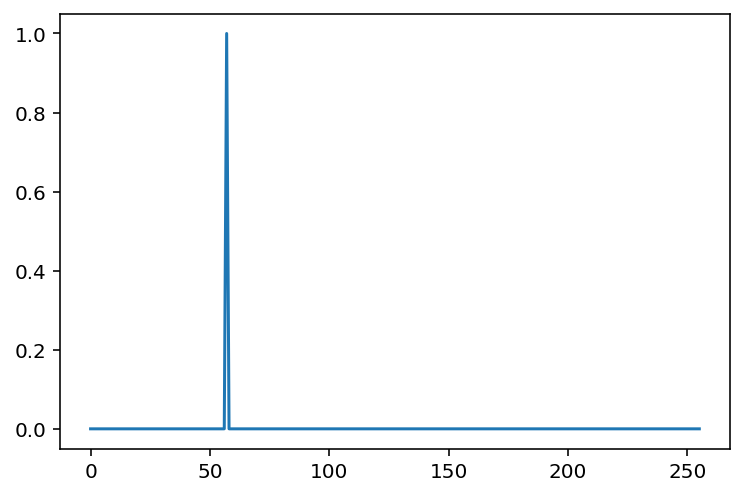

In [14]:
plt.plot(network_input[1,1,:])

In [15]:
network_input = torch.Tensor(network_input)

In [16]:
# max_beta=1.0,  # Maximum KL cost weight, or cost if not annealing.
# beta_rate=0.0,  # Exponential rate at which to anneal KL cost.

In [17]:
# beta = ((1.0 - torch.pow(beta_rate, (self.global_step.float())))
#             * max_beta)

In [18]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [19]:
from model import MusicVAE
from torch.distributions import MultivariateNormal
from torch import optim
from torch import nn


model = MusicVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# Prior distribution.
total_loss = []
epochs = 100
step_num = len(network_input) // 6

for epoch in range(epochs):
    losses = []
    optimizer.zero_grad()
    output, loss = model.forward(network_input.to(device), verbose=1)

    losses.append(loss)
    loss.backward()
    optimizer.step()

    avg_loss = torch.mean(torch.Tensor(losses))
    print(f"Epoch: {epoch}, Loss: {avg_loss}")
    total_loss.append(avg_loss)
    # if avg_loss > torch.mean(torch.Tensor(total_loss[-2:])):
    #     break


c:\Users\leok8\OneDrive\바탕 화면\Works\Learning-Music-Variational-AutoEncoder\model.py:126: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(out)


recon_loss = tensor(0.0258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), kl_loss = tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)
Epoch: 0, Loss: 0.25800061225891113
recon_loss = tensor(0.0258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), kl_loss = tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)
Epoch: 1, Loss: 0.257977694272995
recon_loss = tensor(0.0257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), kl_loss = tensor(0.0041, device='cuda:0', grad_fn=<MulBackward0>)
Epoch: 2, Loss: 0.26133599877357483
recon_loss = tensor(0.0257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), kl_loss = tensor(9.7351e-05, device='cuda:0', grad_fn=<MulBackward0>)
Epoch: 3, Loss: 0.25697144865989685
recon_loss = tensor(0.0257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), kl_loss = tensor(6.6725e-05, device='cuda:0', grad_fn=<MulBackward0>)
Epoch: 4, Loss: 0.256686806678772
recon_loss = tensor(0.0256, device='cuda:0', grad_fn=<BinaryC

KeyboardInterrupt: 

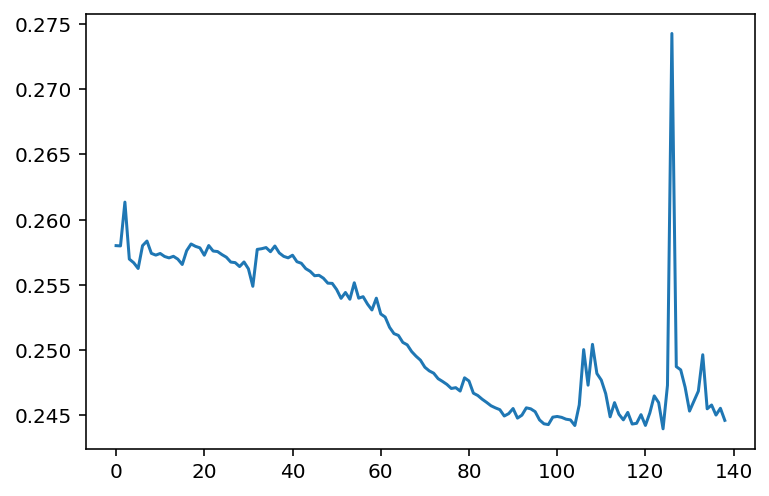

In [20]:
plt.plot(total_loss)

In [29]:
model.initialize_sampler()
sampler = model.sample()

In [30]:
sample = []
for _ in range(256):
    sample += [idx_to_note[torch.argmax(sampler.sample()).item()]]

In [31]:
print(sample)

['B3', '7.9.0', 'C#5', '3.7', '1.5.8', '2.7', '7.10.0', 'D8', 'C4', '2.6.7', '11.2.4', 'E-5', 'F1', '3.6', 'E5', 'A4', '7.9', '10', '4.5.7.9.0', '11.2.4', 'A4', 'B2', 'B-1', '0.3.5', 'F3', '6.10.1', 'C5', '1.6', '2.6.9', '4.7.9.11.0', 'D3', '7.8.10', 'B3', '6.7.10.1', '6', '6.7.11.2', 'G1', '1.4.8', '7.10', 'B2', '4.7.10.0', '3.6.8.10.11', '2.3.5.7.10', '1.4', '6.9', '1.2.6', '0.2', '10.1.5', 'B4', '10.0.5', '8.11', '7.9.0', '4.7.10.0', '9.10.2.5', '7.8.10', '6.9.11.1.2', '4.5.7.9.0', '7.11.1', '5.8.10.1', '2.4.6.7', '5.9.10.0', 'F1', 'G1', '0.3', '4.5.9.0', '0.2.3.7', '5.7.9.0', 'F1', '3.6', '8.11.3', '3.6.8.11', '5.7.0', '11.4', '7.10.0', '2.5.7.9', 'G#2', '4.6.9.11', 'B-5', '9.2', 'A2', '10.0.3', '9.1.4', '4.9', '1.7', '4.8.9.11', '2.3.7', 'D8', '4.9', 'E4', 'D5', '7.9.0', '0.3.5.7.8', '2.4.6', '6.9.11.2', '11.1.2.6', '9.11.0.2.4', 'A2', '9.11.2.4', '10.0.5', '11.4', 'C#3', '10.11.3.6', '6.9.11.1.2', '1.3.5', '3.6.8.11', '0.2.5', 'F#5', 'F#4', '8.10', '2.4.7.9', 'C#5', '6.9.1', '5.1

In [32]:
def create_midi(prediction_output,
                output_path,
                offset_step):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        print(pattern)
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
#         offset += 0.5
#         offset += 1.75
        offset += offset_step

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=output_path)

In [33]:
pwd

'c:\\Users\\leok8\\OneDrive\\바탕 화면\\Works\\Learning-Music-Variational-AutoEncoder'

In [34]:
create_midi(sample, output_path='c:\\Users\\leok8\\OneDrive\\바탕 화면\\Works\\Learning-Music-Variational-AutoEncoder/sample.mid', offset_step=1.0)

B3
7.9.0
C#5
3.7
1.5.8
2.7
7.10.0
D8
C4
2.6.7
11.2.4
E-5
F1
3.6
E5
A4
7.9
10
4.5.7.9.0
11.2.4
A4
B2
B-1
0.3.5
F3
6.10.1
C5
1.6
2.6.9
4.7.9.11.0
D3
7.8.10
B3
6.7.10.1
6
6.7.11.2
G1
1.4.8
7.10
B2
4.7.10.0
3.6.8.10.11
2.3.5.7.10
1.4
6.9
1.2.6
0.2
10.1.5
B4
10.0.5
8.11
7.9.0
4.7.10.0
9.10.2.5
7.8.10
6.9.11.1.2
4.5.7.9.0
7.11.1
5.8.10.1
2.4.6.7
5.9.10.0
F1
G1
0.3
4.5.9.0
0.2.3.7
5.7.9.0
F1
3.6
8.11.3
3.6.8.11
5.7.0
11.4
7.10.0
2.5.7.9
G#2
4.6.9.11
B-5
9.2
A2
10.0.3
9.1.4
4.9
1.7
4.8.9.11
2.3.7
D8
4.9
E4
D5
7.9.0
0.3.5.7.8
2.4.6
6.9.11.2
11.1.2.6
9.11.0.2.4
A2
9.11.2.4
10.0.5
11.4
C#3
10.11.3.6
6.9.11.1.2
1.3.5
3.6.8.11
0.2.5
F#5
F#4
8.10
2.4.7.9
C#5
6.9.1
5.10
6.9.1
4.7.9.0
9.11.0.2.4
C#6
B2
4.8.9.11
B-1
C6
B5
C#5
11.0.4.7
9.11.1.4
0.3.5.8
5.9
F3
2.7
G6
7.0
11.2.4.7
8.11.1.4
8.11.1.4
3.5.10
5.9.0
F#5
10.1.3.5.6
3.6
9.2
7.10.2
10.2
7.10.0.2.3
5.8.10.1
3.6.8.10.11
3.4
D6
1
7.10.0.3
4.7
4
F#5
3
7.9
11.1.4.7
C#4
4.7.11
D6
A2
8.11
D3
2.3.7.10
6.8.10.1.2
10.2
C#5
0.2.4
10.1.3.6
1.2.6
A8
0.2.5
4.9